In [1]:
import numpy as np
import h5py
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn import BatchNorm1d, Linear, ReLU, Sequential
from torch_geometric.nn import DynamicEdgeConv, global_mean_pool
from torch_geometric.data import Batch

In [3]:
path='../project_data/small_set_1_train_0_shuffled.h5'
f = h5py.File(path, "r")
df=pd.DataFrame(f['y'][:])
f.close()
df.columns

Index(['event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x',
       'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x',
       'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2',
       'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y',
       'std_dir_z', 'std_beta0', 'std_lik', 'std_n_hits_gandalf', 'std_pos_x',
       'std_pos_y', 'std_pos_z', 'std_energy', 'std_lik_energy', 'std_length',
       'group_id'],
      dtype='object')

In [2]:
particle_names={-13:'anti muon',14:'muon neutrino',-14:'anti muon neutrino',12:'electron neutrino',-12:'anti electron neutrino'}
#df['names']=df.particle_type.map(particle_names)

In [6]:
df['particles']=df.particle_type.map(particle_names)

In [8]:
counts = df.particles.value_counts()
percent100 = df.particles.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'counts': counts, 'percentage': percent100})

,counts,percentage
anti muon,202755,49.3%
muon neutrino,77905,19.0%
anti muon neutrino,76533,18.6%
anti electron neutrino,29516,7.2%
electron neutrino,24266,5.9%


In [9]:
path='../project_data/small_set_1_validate_0_shuffled.h5'
f_val = h5py.File(path, "r")
df_val=pd.DataFrame(f_val['y'][:])
df_val['names']=df_val.particle_type.map(particle_names)
f_val.close()

In [12]:
counts_val = df_val.names.value_counts()
percent100_val = df_val.names.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
pd.DataFrame({'train set': counts, 'percentage': percent100,'validation set':counts_val,'val percentage':percent100_val}).to_latex('particle.tex')

In [21]:
counts_val.sum()

79767

In [13]:
df[['n_hits','energy','dir_x','dir_y','dir_z']].describe()

,n_hits,energy,dir_x,dir_y,dir_z
count,410975.000000,4.109750e+05,410975.000000,410975.000000,410975.000000
mean,119.214570,1.492275e+05,0.002461,-0.000874,-0.367168
std,355.315833,2.485723e+06,0.513704,0.520422,0.574849
min,19.000000,1.000000e+00,-0.999999,-0.999995,-1.000000
25%,60.000000,3.968400e+01,-0.408556,-0.423245,-0.830912
50%,80.000000,2.128430e+02,0.002023,-0.001346,-0.605021
75%,111.000000,6.867875e+02,0.413999,0.421113,0.041697
max,18195.000000,9.997210e+07,1.000000,1.000000,0.999984


In [14]:
df[['particle_type','energy','dir_x','dir_y','dir_z']].corr()

,particle_type,energy,dir_x,dir_y,dir_z
particle_type,1.000000,0.034707,0.000462,0.000305,0.388561
energy,0.034707,1.000000,0.002419,0.000075,0.017810
dir_x,0.000462,0.002419,1.000000,0.017777,0.004242
dir_y,0.000305,0.000075,0.017777,1.000000,0.000140
dir_z,0.388561,0.017810,0.004242,0.000140,1.000000


In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
result=pca.fit_transform(df[['energy','dir_x','dir_y','dir_z']].values)

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(result[:,0],result[:,1],c=df.particle_type)
plt.show()

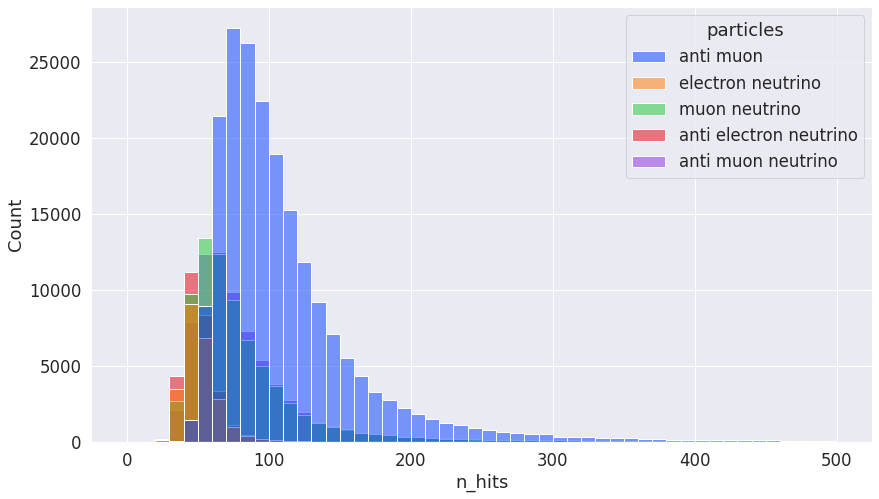

In [15]:
import seaborn as sns
sns.set(rc={"figure.figsize":(14, 8)},font_scale=1.5) 
sns_plot = sns.histplot(data = df, x='n_hits',hue='particles', binwidth = 10, binrange=[0,500],palette="bright")
fig = sns_plot.get_figure()
fig.savefig("n_hits_histogram.pdf")

In [ ]:
df.columns

In [67]:
for x in f['x'].attrs:
    print(f['x'].attrs[x])

b'EARRAY'
0
b'nodes'
b'1.1'
channel_id
dir_x
pos_z
t0
time
tot
triggered
is_valid
dir_y
dir_z
dom_id
du
floor
group_id
pos_x
pos_y


In [24]:
path='../project_data/small_set_1_train_0_shuffled.h5'
features=['channel_id','dom_id','du','floor']
with h5py.File(path, "r") as f:
    x_feature_dict = {f["x"].attrs[f"hit_info_{i}"]: i for i in range(f["x"].shape[-1])}
    x_mask = np.array([x_feature_dict[feat] for feat in features])
    total=np.empty((0,4))
    for i in range(50):
        array=f["x"][0:200,i,x_mask] 
        array=array[np.sum(array,axis=1)>0,:]
        total=np.vstack([total,array])
du_info=pd.DataFrame(total,columns = features)
du_info

,channel_id,dom_id,du,floor
0,11.0,808972672.0,2.0,2.0
1,11.0,808972672.0,2.0,2.0
2,17.0,808969856.0,2.0,2.0
3,17.0,808982080.0,2.0,2.0
4,25.0,808972672.0,2.0,2.0
...,...,...,...,...
9827,2.0,808976384.0,4.0,4.0
9828,23.0,808982528.0,4.0,4.0
9829,16.0,808972608.0,4.0,4.0
9830,9.0,808996800.0,5.0,5.0


In [26]:
len(du_info.dom_id.unique())

52

In [68]:
features=['t0','time','tot','triggered']
x_feature_dict = {f["x"].attrs[f"hit_info_{i}"]: i for i in range(f["x"].shape[-1])}
x_mask = np.array([x_feature_dict[feat] for feat in features])

In [70]:
total=np.empty((0,4))
for i in range(100):
    array=f["x"][0:200,i,x_mask] 
    array=array[np.sum(array,axis=1)>0,:]
    total=np.vstack([total,array])
time_info=pd.DataFrame(total,columns = features)
time_info

,t0,time,tot,triggered
0,207102.218750,169.761002,30.0,0.0
1,207102.218750,-182.335007,18.0,0.0
2,207211.265625,-454.595001,24.0,0.0
3,207158.968750,-588.705994,26.0,0.0
4,207098.968750,133.985992,24.0,0.0
...,...,...,...,...
15520,207975.531250,204.664001,26.0,1.0
15521,208074.093750,-390.963989,24.0,0.0
15522,207478.515625,238.643005,46.0,1.0
15523,208075.703125,653.658020,26.0,0.0


In [74]:
time_info.describe()

,t0,time,tot,triggered
count,15525.000000,15525.000000,15525.000000,15525.000000
mean,207724.807858,165.054424,26.282705,0.377842
std,304.625721,418.986485,10.107367,0.484863
min,207098.078125,-1008.117981,1.000000,0.000000
25%,207485.437500,4.944000,23.000000,0.000000
50%,207701.343750,111.026001,26.000000,0.000000
75%,207978.140625,357.565002,29.000000,1.000000
max,208401.968750,1596.197021,218.000000,1.000000


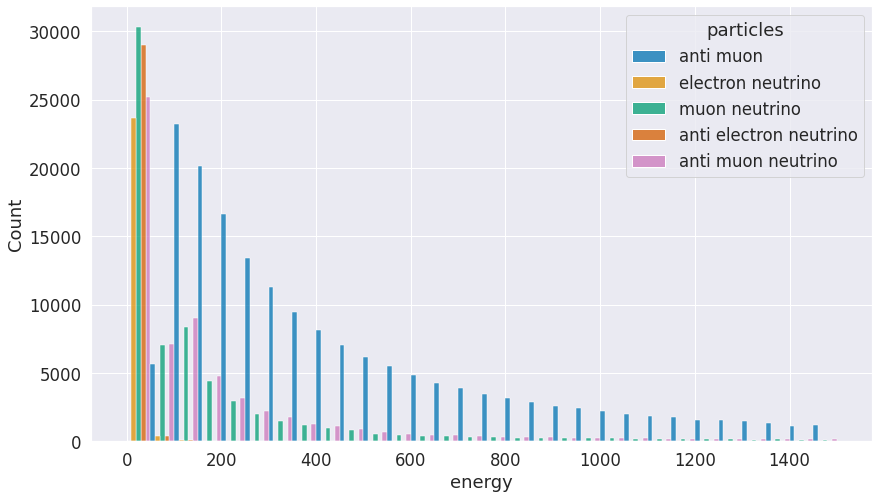

In [16]:
import seaborn as sns
#sns.set(rc={"figure.figsize":(14, 8)}) 
sns.color_palette("bright")
sns_plot = sns.histplot(data = df, x='energy',hue='particles', binwidth = 50, binrange=[0,1500],multiple="dodge", palette="colorblind")
fig = sns_plot.get_figure()
fig.savefig("energy_histogram.pdf")

In [17]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

In [19]:
experiment_id = "version_31"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
df

_MultiThreadedRendezvous: <_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.INTERNAL
	details = "Internal error. Please report this and specify reference code 230fc4d3-2377-4181-bc9c-96d6ecb945a8."
	debug_error_string = "{"created":"@1620905292.033882899","description":"Error received from peer ipv4:34.95.66.171:443","file":"src/core/lib/surface/call.cc","file_line":1061,"grpc_message":"Internal error. Please report this and specify reference code 230fc4d3-2377-4181-bc9c-96d6ecb945a8.","grpc_status":13}"
>

In [ ]:
X
t0  -> is dit tijd tov t0?
time -> wat betekend dit en waarom is hij soms negatief?
triggered ->?
is_valid -> Padding?
du -> ik zie du's 2 t/m 5, klopt dat?
group_id -> ?

Y
bjorkeny -> is dit een belangrijke waarde?
std_n_hits_gandalf -> LOTR??!

In [ ]:
class HDF5Dataset(Dataset):
    def __init__(self, path, features=["pos_x", "pos_y", "pos_z", "time", "dir_x", "dir_y", "dir_z"], y_feature="particle_type", particle_type=13.0, batch_size=64):
        """ Loads the data from the hdf5 format provided by OrcaSong and converts it to data that can be used by PyTorch
        
        Args:
            path (str): path to the dataset
            features (list[str]): List of features to select from the event data and use as input features
            y_feature  (str): Output feature to select
            particle_type (None or float):  ID of the particle you want to classify, it will be label 0 and all else will be label 1.
                                            Must be None when y_feature is not `particle_type`
            batch_size (int): number of samples in mini batch
        Examples:
            Electron vs Background classification (default):
            ```
                HDF5Dataset("pathtodata.h5", y_feature="particle_type", particle_type=13.0)
            ```
            Energy regression with only xyzct:
            ```
                HDF5Dataset("pathtodata.h5", features=["pos_x", "pos_y", "pos_z", "time"], y_feature="energy", particle_type=None)
            ```

        Lookup of table for particle_type of Leptons:
          electron          | 11
          electron neutrino | 12
          muon              | 13
          muon neutrino     | 14
          tau               | 15
          tau neutrino      | 16
        Antiparticle is the same as particle but with minus sign
        Source: https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf
        """
        with h5py.File(path, "r") as f:
            self.groups = list(dict(f).keys())
            self.length = len(f["y"]) // batch_size + 1
            self._max_index = len(f["y"])
            print("The available y features are: ", f["y"][0].dtype.names)
        self.filename = path
        if y_feature!="particle_type":
            assert particle_type==None, "Selected a y_feature other than 'particle_type' and specified some value for particle_type as argument, which must be None for non particle_type output feature."
        self.y_feature = y_feature
        self.particle_type = particle_type
        self.batch_size = batch_size
        self._cache_x_column_names()
        self.x_mask = self.init_x_mask(features)


    def _cache_x_column_names(self):
        """Cache which columns are available in the features

        Raises:
            ValueError: It failed to read the hit_info columns
        """
        try:
            with h5py.File(self.filename, "r") as f:
                self.x_feature_dict = {
                    f["x"].attrs[f"hit_info_{i}"]: i for i in range(f["x"].shape[-1])
                }
            print("cached the following x input features", self.x_feature_dict)
        except Exception:
            raise ValueError("Can not read column names from dataset attributes")

    def init_x_mask(self, features):
        """Compute a mask that is used to select the feature columns from the data

        Args:
            features (list[str]): list of features present to load

        Returns:
            np.array: selection of column index from the features to use
        """
        x_mask = [self.x_feature_dict[feat] for feat in features]
        return np.array(x_mask)

    def __getitem__(self, index):
        """Get an sample from the h5 dataset
        x contains: (x,y,z,ct, dir_x, dir_y, dir_z)
        y contains a label neutrino (1) or muon (0)

        Args:
            index (int): index of the batch

        Returns:
            x (torch.Tensor): Tensor with the x data (for each of the vertices)
            y (torch.Tensor): Tensor with the y data (for the graph)
            batch_idx (torch.Tensor): Tensor that assigns the right batch index to each x point
        """
        with h5py.File(self.filename, "r") as f:
            if (index + 1) * self.batch_size >= self._max_index:
                  index = slice(index * self.batch_size, self._max_index)
            else:
                  index = slice(index * self.batch_size, (index + 1) * self.batch_size)
            x = f["x"][index][:]
            lengths = (np.sum(x[:, :, -1:], axis=1)).astype(int)
            batch_idx = np.hstack(
                  [
                      np.ones(length) * batch_idx
                      for batch_idx, length in enumerate(lengths)
                  ]
              )
            x = x[x[:, :, -1] == 1][:, self.x_mask]
            y = f["y"][index][:][self.y_feature]
            if self.y_feature=="particle_type" and self.particle_type:
                y = torch.LongTensor(~(abs(y) == self.particle_type))
            else:
                y = torch.Tensor(y)
        return x, y, torch.LongTensor(batch_idx)

    def __len__(self):
        return self.length


In [ ]:
class DECNetwork(pl.LightningModule):
    def __init__(self, batchnorm_kwargs=None, conf=None):
        """Dynamic EdgeConvolution Network https://arxiv.org/abs/1801.07829 with
           the dynamic KNN computation as presented in https://arxiv.org/abs/1902.08570 """
        super().__init__()
        ## Lightning configuration
        self.accuracy = pl.metrics.Accuracy()
        ## Defining the Network Architecture
        nn = Sequential(
            Linear(2 * 7, 64),
            BatchNorm1d(64, **batchnorm_kwargs),
            ReLU(),
            Linear(64, 64),
            BatchNorm1d(64, **batchnorm_kwargs),
            ReLU(),
            Linear(64, 64),
            BatchNorm1d(64, **batchnorm_kwargs),
            ReLU(),
        )
        self.edge_1 = DynamicEdgeConv(nn, aggr="mean", k=32)
        nn = Sequential(
            Linear(128, 128),
            BatchNorm1d(128, **batchnorm_kwargs),
            ReLU(),
            Linear(128, 128),
            BatchNorm1d(128, **batchnorm_kwargs),
            ReLU(),
            Linear(128, 128),
            BatchNorm1d(128, **batchnorm_kwargs),
            ReLU(),
        )
        self.edge_2 = DynamicEdgeConv(nn, aggr="mean", k=32)
        nn = Sequential(
            Linear(256, 256),
            BatchNorm1d(256, **batchnorm_kwargs),
            ReLU(),
            Linear(256, 256),
            BatchNorm1d(256, **batchnorm_kwargs),
            ReLU(),
            Linear(256, 256),
            BatchNorm1d(256, **batchnorm_kwargs),
            ReLU(),
        )
        self.edge_3 = DynamicEdgeConv(nn, aggr="mean", k=32)
        self.shortcut_1 = Sequential(Linear(7, 64), BatchNorm1d(64), ReLU())
        self.shortcut_2 = Sequential(Linear(64, 128), BatchNorm1d(128), ReLU())
        self.shortcut_3 = Sequential(Linear(128, 256), BatchNorm1d(256), ReLU())
        self.lin_1 = Linear(256, 256)
        self.lin_2 = Linear(256, 128)
        self.lin_3 = Linear(128, 2)

    def forward(self, data):
        x, batch_idx = data.x, data.batch
        # in lightning, forward defines the prediction/inference actions
        # edgeconv layer 1
        sc = self.shortcut_1(x)
        x = self.edge_1(x, batch_idx)
        x = F.relu(x + sc)
        # edgeconv layer 2
        sc = self.shortcut_2(x)
        x = self.edge_2(x, batch_idx)
        x = F.relu(x + sc)
        # edgeconv layer 3
        sc = self.shortcut_3(x)
        x = self.edge_3(x, batch_idx)
        x = F.relu(x + sc)
        x = global_mean_pool(x, batch=batch_idx)
        # now apply
        x = F.relu(self.lin_1(x))
        x = F.relu(self.lin_2(x))
        x = self.lin_3(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        batch = Batch(
            x=batch[0].squeeze(), y=batch[1].squeeze(), batch=batch[2].squeeze(),
        )
        out = self.forward(batch)
        loss = F.nll_loss(out, batch.y)
        self.log("train_loss", loss)
        self.log('train_acc_step', self.accuracy(out, batch.y), on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        batch = Batch(
            x=batch[0].squeeze(), y=batch[1].squeeze(), batch=batch[2].squeeze(),
        )
        y_hat = self.forward(batch)
        loss = F.nll_loss(y_hat, batch.y)
        self.log("val_loss", loss)
        self.log('valid_acc', self.accuracy(y_hat, batch.y), on_step=True, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [41]:
cm=np.array([[ 1040,  3065,  2317,     1,  8206],    # -14
             [  116, 38262,    35,     0,   565],    # -13
             [    7,    88,  4287,     5,  1781],    # -12
             [    7,    82,  3360,     2,  1556],    #  12 
             [  869,  2711,  2789,     4,  8613]])   #  14

In [42]:
cm_temp=np.zeros((3,5)).astype('int64')
cm_temp[0,:]=cm[2,:]+cm[3,:]   # 12
cm_temp[1,:]=cm[1,:]           # 13
cm_temp[2,:]=cm[0,:]+cm[4,:]   # 14
cm_temp

array([[   14,   170,  7647,     7,  3337],
       [  116, 38262,    35,     0,   565],
       [ 1909,  5776,  5106,     5, 16819]])

In [43]:
cm_new=np.zeros((3,3)).astype('int64')
cm_new[:,0] = cm_temp[:,2]+cm_temp[:,3]
cm_new[:,1] = cm_temp[:,1]
cm_new[:,2] = cm_temp[:,0]+cm_temp[:,4]
cm_new

array([[ 7654,   170,  3351],
       [   35, 38262,   681],
       [ 5111,  5776, 18728]])

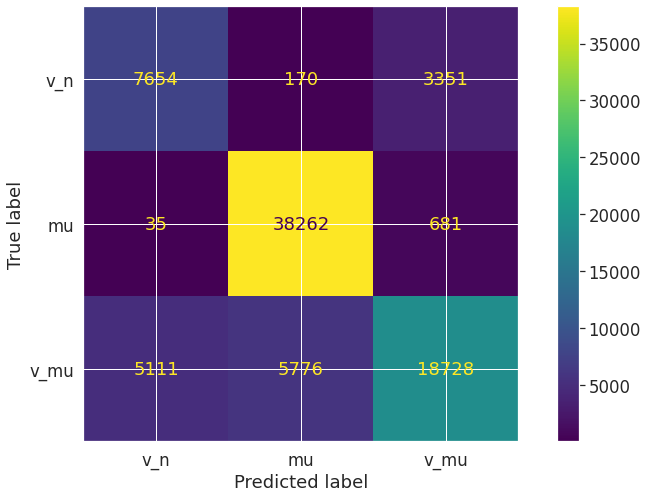

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay
labels=['v_n','mu','v_mu']
disp=ConfusionMatrixDisplay(cm_new,display_labels=labels)
disp.plot()

In [67]:
print('accuracy:', np.trace(cm_new)/np.sum(cm_new))
print()
print('muon precision:', cm_new[1,1]/np.sum(cm_new[:,1]))
print('neutrino precision:', (cm_new[0,0]+cm_new[2,2]+cm_new[0,2]+cm_new[2,0])/np.sum(cm_new[:,[True,False,True]]))
print('neutrino flavour precision:', (cm_new[0,0]+cm_new[2,2])/np.sum(cm_new[:,[True,False,True]]))
print()
print('muon recall:', cm_new[1,1]/np.sum(cm_new[1,:]))
print('neutrino recall:', (cm_new[0,0]+cm_new[2,2]+cm_new[0,2]+cm_new[2,0])/np.sum(cm_new[[True,False,True],:]))
print('neutrino flavour recall:', (cm_new[0,0]+cm_new[2,2])/np.sum(cm_new[[True,False,True],:]))


accuracy: 0.8104001604653495

muon precision: 0.865499457111835
neutrino precision: 0.9798650168728908
neutrino flavour precision: 0.7419010123734533

muon recall: 0.9816306634511776
neutrino recall: 0.8542289776906105
neutrino flavour recall: 0.6467761706300564


In [62]:
disp.figure_.savefig('confusion_matrix_new_run31')
disp.figure_.savefig('confusion_matrix_new_run31.pdf')